# K-Means Clustering (Unsupervised): From Scratch vs Library (Window Size = 14)

- Dataset: `CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv`
- Target (for evaluation only): `Target_Return_7d` mapped to 3 classes
  - Uptrend: `> 0.03`
  - Downtrend: `< -0.03`
  - Sideway: otherwise
- Features: selected from `CLASSIFY-AMZN_methods_all_in_one.csv`
- Models:
  1. K-Means (from scratch — Lloyd's algorithm)
  2. K-Means (scikit-learn KMeans)
- Cluster labels are mapped to true labels via best permutation (Hungarian algorithm)

Outputs:
- Loss (inertia / within-cluster sum of squares)
- Confusion matrix
- Accuracy
- Precision, Recall, Specificity (macro), F1-score
- ROC & AUC (multiclass, OvR — using softmax of negative distances as proxy probabilities)
- Performance curves (inertia convergence over iterations)

Rows after cleaning: 4022
Number of features used: 9
Features used: ['ma_gap_20', 'vol_10', 'vol_20', 'lower_wick', 'upper_wick', 'ret_1', 'range_pct', 'co_ret', 'ret_5']

Target mapping (used for evaluation only — clustering is unsupervised):
  > 0.03 -> Uptrend (2)
  < -0.03 -> Downtrend (0)
  otherwise -> Sideway (1)
Class distribution: {'Downtrend': 784, 'Sideway': 2035, 'Uptrend': 1203}
Training K-Means from scratch (K=3) ...
  Converged at iteration 22
  Scratch cluster->class mapping: {0: 0, 1: 2, 2: 1}
  Scratch inertia: 317984.15

  Library cluster->class mapping: {0: 2, 1: 1, 2: 0}
  Library inertia: 317983.99

=== Silhouette Scores (Test Set) ===
Scratch: 0.0881
Library: 0.0872

=== Loss ===
Scratch log loss: 2.153366
Library log loss: 2.152882

=== Confusion Matrix (rows=true, cols=pred) ===
Class order: ['Downtrend', 'Sideway', 'Uptrend']
Scratch:
 [[ 28  97  34]
 [ 61 205 129]
 [ 42 128  78]]
Library:
 [[ 28  97  34]
 [ 61 204 130]
 [ 42 127  79]]

=== Per-Class Metrics (

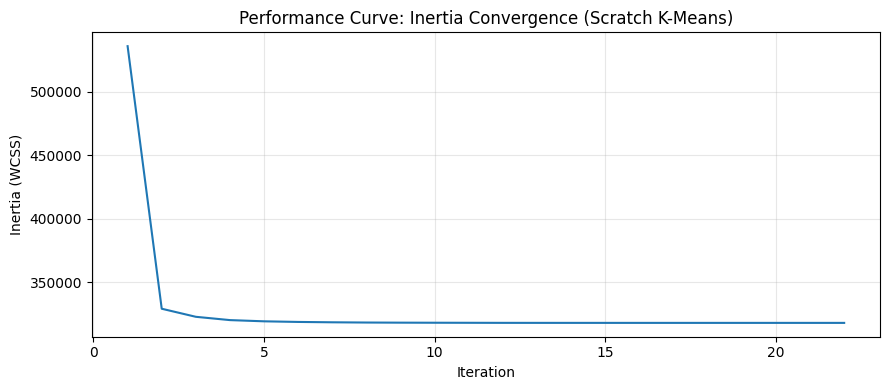

  Converged at iteration 2
  Converged at iteration 13
  Converged at iteration 22
  Converged at iteration 46
  Converged at iteration 52
  Converged at iteration 28
  Converged at iteration 18
  Converged at iteration 40
  Converged at iteration 46
  Converged at iteration 53


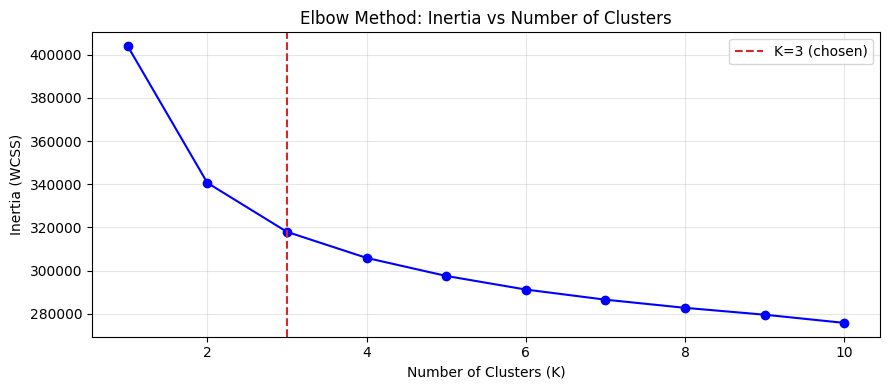

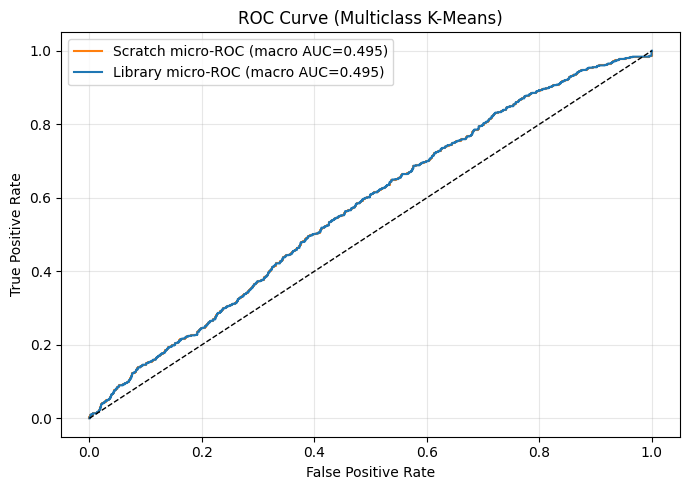

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations

from sklearn.cluster import KMeans
from sklearn.metrics import (
    log_loss,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    mean_squared_error,
    r2_score,
    roc_curve,
    roc_auc_score,
    silhouette_score
)
from sklearn.preprocessing import label_binarize

WINDOW_SIZE = 14
DATA_PATH = '../CLASSIFY-SnP_daily_update_AMZN_features_with_target.csv'
FEATURE_PATH = '../CLASSIFY-AMZN_methods_all_in_one.csv'
TARGET_COL = 'Target_Return_7d'

# Thresholds for 3-class target mapping
UP_THRESHOLD = 0.03
DOWN_THRESHOLD = -0.03
K = 3  # number of clusters (matches number of classes)

# --------------------------
# 1) Load data and features
# --------------------------
df = pd.read_csv(DATA_PATH)
feature_df = pd.read_csv(FEATURE_PATH)

requested_features = [
    'ma_gap_20', 'vol_10', 'vol_20',
    'lower_wick', 'upper_wick',
    'ret_1',
    'range_pct',
    'co_ret',
    'ret_5'
]
allowed_features = feature_df['feature'].tolist() if 'feature' in feature_df.columns else []
feature_cols = [c for c in requested_features if c in allowed_features and c in df.columns and c != TARGET_COL]
missing = [c for c in requested_features if c not in feature_cols]
if missing:
    print('Missing features:', missing)

# Basic cleaning and sorting (time series)
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)

model_df = df[feature_cols + [TARGET_COL]].copy()
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)

print(f'Rows after cleaning: {len(model_df)}')
print(f'Number of features used: {len(feature_cols)}')
print('Features used:', feature_cols)

# --------------------------------
# 2) Build sliding window features
# --------------------------------
def make_windows(x_values, y_values, window_size=14):
    Xw, yw = [], []
    for i in range(window_size, len(x_values)):
        Xw.append(x_values[i-window_size:i].reshape(-1))
        yw.append(y_values[i])
    return np.array(Xw, dtype=np.float64), np.array(yw, dtype=np.int64)

def map_target_3class(y_values, up_thr=0.03, down_thr=-0.03):
    y_cls = np.full_like(y_values, 1, dtype=np.int64)  # 1 = Sideway
    y_cls[y_values > up_thr] = 2                        # 2 = Up
    y_cls[y_values < down_thr] = 0                      # 0 = Down
    return y_cls

CLASS_LABELS = {0: 'Downtrend', 1: 'Sideway', 2: 'Uptrend'}

X_raw = model_df[feature_cols].values.astype(np.float64)
y_raw_cont = model_df[TARGET_COL].values.astype(np.float64)
y_raw = map_target_3class(y_raw_cont, up_thr=UP_THRESHOLD, down_thr=DOWN_THRESHOLD)

print('\nTarget mapping (used for evaluation only — clustering is unsupervised):')
print(f'  > {UP_THRESHOLD:.2f} -> Uptrend (2)')
print(f'  < {DOWN_THRESHOLD:.2f} -> Downtrend (0)')
print('  otherwise -> Sideway (1)')
print('Class distribution:', {CLASS_LABELS[k]: int((y_raw == k).sum()) for k in sorted(CLASS_LABELS)})

X_win, y_win = make_windows(X_raw, y_raw, window_size=WINDOW_SIZE)

# Chronological split (80/20)
split_idx = int(len(X_win) * 0.8)
X_train_raw, X_test_raw = X_win[:split_idx], X_win[split_idx:]
y_train, y_test = y_win[:split_idx], y_win[split_idx:]

# Standardize by train statistics
x_mean = X_train_raw.mean(axis=0)
x_std = X_train_raw.std(axis=0)
x_std = np.where(x_std == 0, 1.0, x_std)

X_train = (X_train_raw - x_mean) / x_std
X_test = (X_test_raw - x_mean) / x_std

# -------------------------------------------------------
# 3) Helper: map cluster labels to true labels (Hungarian)
# -------------------------------------------------------
def best_cluster_label_mapping(y_true, y_cluster, n_classes=3):
    """Find the permutation of cluster labels that maximizes accuracy."""
    best_acc = -1
    best_perm = None
    for perm in permutations(range(n_classes)):
        mapped = np.array([perm[c] for c in y_cluster])
        acc = np.mean(mapped == y_true)
        if acc > best_acc:
            best_acc = acc
            best_perm = perm
    return best_perm, best_acc

def apply_mapping(y_cluster, perm):
    return np.array([perm[c] for c in y_cluster], dtype=np.int64)

def cluster_distances_to_proba(X, centroids):
    """Convert distances to centroids into proxy probabilities via softmax of negative distances."""
    dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  # (n, k)
    neg_dists = -dists
    neg_dists_stable = neg_dists - np.max(neg_dists, axis=1, keepdims=True)
    exp_d = np.exp(neg_dists_stable)
    return exp_d / np.sum(exp_d, axis=1, keepdims=True)

# --------------------------------------------------
# 4) K-Means from Scratch (Lloyd's Algorithm)
# --------------------------------------------------
class KMeansScratch:
    """K-Means clustering from scratch using Lloyd's algorithm."""
    def __init__(self, k=3, max_iter=300, tol=1e-6, random_state=42):
        self.k = k
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.inertia_history = []   # within-cluster sum of squares per iteration
        self.labels_ = None
        self.inertia_ = None

    def fit(self, X):
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape

        # K-Means++ initialization
        centroids = np.empty((self.k, n_features), dtype=np.float64)
        centroids[0] = X[rng.randint(n_samples)]
        for c in range(1, self.k):
            dists = np.min(np.linalg.norm(X[:, np.newaxis, :] - centroids[:c][np.newaxis, :, :], axis=2), axis=1)
            probs = dists ** 2
            probs /= probs.sum()
            centroids[c] = X[rng.choice(n_samples, p=probs)]

        self.inertia_history = []
        for iteration in range(self.max_iter):
            # Assignment step
            dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  # (n, k)
            labels = np.argmin(dists, axis=1)

            # Inertia (WCSS)
            inertia = sum(np.sum((X[labels == c] - centroids[c]) ** 2) for c in range(self.k))
            self.inertia_history.append(inertia)

            # Update step
            new_centroids = np.empty_like(centroids)
            for c in range(self.k):
                members = X[labels == c]
                if len(members) > 0:
                    new_centroids[c] = members.mean(axis=0)
                else:
                    new_centroids[c] = X[rng.randint(n_samples)]  # reinitialize empty cluster

            # Convergence check
            shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            if shift < self.tol:
                print(f'  Converged at iteration {iteration + 1}')
                break

        self.centroids = centroids
        self.labels_ = labels
        self.inertia_ = self.inertia_history[-1]
        return self

    def predict(self, X):
        dists = np.linalg.norm(X[:, np.newaxis, :] - self.centroids[np.newaxis, :, :], axis=2)
        return np.argmin(dists, axis=1)

    def predict_proba(self, X):
        """Proxy probabilities via softmax of negative distances."""
        return cluster_distances_to_proba(X, self.centroids)


print(f'Training K-Means from scratch (K={K}) ...')
scratch_model = KMeansScratch(k=K, max_iter=300, random_state=42)
scratch_model.fit(X_train)
cluster_train_scratch = scratch_model.predict(X_train)
cluster_test_scratch = scratch_model.predict(X_test)

# Map scratch cluster labels to true class labels
perm_scratch, _ = best_cluster_label_mapping(y_test, cluster_test_scratch, n_classes=K)
y_pred_scratch = apply_mapping(cluster_test_scratch, perm_scratch)
# Reorder centroids for probability computation to match mapped labels
centroid_order_scratch = list(perm_scratch)
reordered_centroids_scratch = scratch_model.centroids.copy()
# Build probability matrix with columns reordered to match class labels
raw_proba_scratch = scratch_model.predict_proba(X_test)
y_prob_scratch = np.zeros_like(raw_proba_scratch)
for orig_cluster, mapped_class in enumerate(perm_scratch):
    y_prob_scratch[:, mapped_class] = raw_proba_scratch[:, orig_cluster]

print(f'  Scratch cluster->class mapping: {dict(enumerate(perm_scratch))}')
print(f'  Scratch inertia: {scratch_model.inertia_:.2f}')

# -------------------------------------
# 5) K-Means Library (scikit-learn)
# -------------------------------------
lib_model = KMeans(n_clusters=K, max_iter=300, random_state=42, n_init=10)
lib_model.fit(X_train)
cluster_test_lib = lib_model.predict(X_test)

perm_lib, _ = best_cluster_label_mapping(y_test, cluster_test_lib, n_classes=K)
y_pred_lib = apply_mapping(cluster_test_lib, perm_lib)
raw_proba_lib = cluster_distances_to_proba(X_test, lib_model.cluster_centers_)
y_prob_lib = np.zeros_like(raw_proba_lib)
for orig_cluster, mapped_class in enumerate(perm_lib):
    y_prob_lib[:, mapped_class] = raw_proba_lib[:, orig_cluster]

print(f'\n  Library cluster->class mapping: {dict(enumerate(perm_lib))}')
print(f'  Library inertia: {lib_model.inertia_:.2f}')

# Silhouette scores
sil_scratch = silhouette_score(X_test, cluster_test_scratch)
sil_lib = silhouette_score(X_test, cluster_test_lib)
print(f'\n=== Silhouette Scores (Test Set) ===')
print(f'Scratch: {sil_scratch:.4f}')
print(f'Library: {sil_lib:.4f}')

# ------------------------
# 6) Metrics and outputs
# ------------------------
classes = np.array([0, 1, 2])

loss_scratch = log_loss(y_test, y_prob_scratch, labels=classes)
loss_lib = log_loss(y_test, y_prob_lib, labels=classes)

cm_scratch = confusion_matrix(y_test, y_pred_scratch, labels=classes)
cm_lib = confusion_matrix(y_test, y_pred_lib, labels=classes)

acc_scratch = accuracy_score(y_test, y_pred_scratch)
acc_lib = accuracy_score(y_test, y_pred_lib)

precision_scratch = precision_score(y_test, y_pred_scratch, average='macro', zero_division=0)
precision_lib = precision_score(y_test, y_pred_lib, average='macro', zero_division=0)

recall_scratch = recall_score(y_test, y_pred_scratch, average='macro', zero_division=0)
recall_lib = recall_score(y_test, y_pred_lib, average='macro', zero_division=0)

f1_scratch = f1_score(y_test, y_pred_scratch, average='macro', zero_division=0)
f1_lib = f1_score(y_test, y_pred_lib, average='macro', zero_division=0)

mse_scratch = mean_squared_error(y_test, y_pred_scratch)
mse_lib = mean_squared_error(y_test, y_pred_lib)
rmse_scratch = np.sqrt(mse_scratch)
rmse_lib = np.sqrt(mse_lib)
r2_scratch = r2_score(y_test, y_pred_scratch)
r2_lib = r2_score(y_test, y_pred_lib)

def multiclass_macro_specificity(cm):
    total = np.sum(cm)
    specs = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = total - (tp + fp + fn)
        specs.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
    return float(np.mean(specs))

specificity_scratch = multiclass_macro_specificity(cm_scratch)
specificity_lib = multiclass_macro_specificity(cm_lib)

print('\n=== Loss ===')
print(f'Scratch log loss: {loss_scratch:.6f}')
print(f'Library log loss: {loss_lib:.6f}')

print('\n=== Confusion Matrix (rows=true, cols=pred) ===')
print('Class order:', [CLASS_LABELS[c] for c in classes])
print('Scratch:\n', cm_scratch)
print('Library:\n', cm_lib)

p_s, r_s, f_s, sup_s = precision_recall_fscore_support(y_test, y_pred_scratch, labels=classes, zero_division=0)
p_l, r_l, f_l, sup_l = precision_recall_fscore_support(y_test, y_pred_lib, labels=classes, zero_division=0)

print('\n=== Per-Class Metrics (Scratch) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_s[i]:.4f} | Recall: {r_s[i]:.4f} | F1: {f_s[i]:.4f} | Support: {sup_s[i]}")

print('\n=== Per-Class Metrics (Library) ===')
for i, c in enumerate(classes):
    print(f"{CLASS_LABELS[c]:<10} | Precision: {p_l[i]:.4f} | Recall: {r_l[i]:.4f} | F1: {f_l[i]:.4f} | Support: {sup_l[i]}")

print('\n=== Metrics Summary (Macro) ===')
print(f'Accuracy - Scratch: {acc_scratch:.4f} | Library: {acc_lib:.4f}')
print(f'Precision - Scratch: {precision_scratch:.4f} | Library: {precision_lib:.4f}')
print(f'Recall - Scratch: {recall_scratch:.4f} | Library: {recall_lib:.4f}')
print(f'Specificity - Scratch: {specificity_scratch:.4f} | Library: {specificity_lib:.4f}')
print(f'F1-score - Scratch: {f1_scratch:.4f} | Library: {f1_lib:.4f}')

print('\n=== Additional Numeric Metrics (Label-Encoded) ===')
print(f'MSE - Scratch: {mse_scratch:.4f} | Library: {mse_lib:.4f}')
print(f'RMSE - Scratch: {rmse_scratch:.4f} | Library: {rmse_lib:.4f}')
print(f'R² - Scratch: {r2_scratch:.4f} | Library: {r2_lib:.4f}')

# ROC & AUC (multiclass OvR + micro-curve for plotting)
y_test_bin = label_binarize(y_test, classes=classes)

roc_auc_s = roc_auc_score(y_test_bin, y_prob_scratch, average='macro', multi_class='ovr')
roc_auc_l = roc_auc_score(y_test_bin, y_prob_lib, average='macro', multi_class='ovr')

fpr_s, tpr_s, _ = roc_curve(y_test_bin.ravel(), y_prob_scratch.ravel())
fpr_l, tpr_l, _ = roc_curve(y_test_bin.ravel(), y_prob_lib.ravel())

print('\n=== ROC & AUC (Multiclass OvR Macro AUC) ===')
print(f'Scratch AUC: {roc_auc_s:.4f}')
print(f'Library AUC: {roc_auc_l:.4f}')

# ---------------------------------------------------------
# 7) Performance curves (inertia convergence) and ROC
# ---------------------------------------------------------
# Performance curve: Inertia convergence (scratch)
plt.figure(figsize=(9, 4))
plt.plot(range(1, len(scratch_model.inertia_history) + 1), scratch_model.inertia_history, color='tab:blue')
plt.title('Performance Curve: Inertia Convergence (Scratch K-Means)')
plt.xlabel('Iteration')
plt.ylabel('Inertia (WCSS)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Elbow plot: run K-Means for K=1..10 to show optimal K
inertias = []
k_range = range(1, 11)
for k in k_range:
    km = KMeansScratch(k=k, max_iter=200, random_state=42)
    km.fit(X_train)
    inertias.append(km.inertia_)

plt.figure(figsize=(9, 4))
plt.plot(k_range, inertias, 'bo-')
plt.axvline(x=K, color='tab:red', linestyle='--', label=f'K={K} (chosen)')
plt.title('Elbow Method: Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curve (micro-averaged one-vs-rest)
plt.figure(figsize=(7, 5))
plt.plot(fpr_s, tpr_s, label=f'Scratch micro-ROC (macro AUC={roc_auc_s:.3f})', color='tab:orange')
plt.plot(fpr_l, tpr_l, label=f'Library micro-ROC (macro AUC={roc_auc_l:.3f})', color='tab:blue')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title('ROC Curve (Multiclass K-Means)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()